Here we analyze the raw data obtained from the _QPC_dd_sim.py_ script.

In [1]:
import numpy as np
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import json
import matplotlib

In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 17

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

In [3]:
def load_data(dir_route, file):
    # loading the simulation data
    with h5py.File(dir_route+file, 'r') as res_h5:
        Param_dict = json.loads(res_h5['metadata/parameters'][()])

        # load qpc data
        N_bond = res_h5["results/QPC_bond_density"][:]
        N_left = res_h5["results/QPC_left_density"][:]
        N_right = res_h5["results/QPC_right_density"][:]
        N_last = res_h5["results/QPC_last_site_density"][:]

        # load dot data
        N_d1 = res_h5["results/d1_density"][:]
        N_d2 = res_h5["results/d2_density"][:]

        # time range
        Times = res_h5["results/time"][:]
        
        # trajectories
        Trajectories = res_h5["results/trajectories"][:]

    res_h5.close()
    
    return Param_dict,Times, N_bond, N_left, N_right, N_last, N_d1, N_d2,Trajectories
    

In [4]:
data_route = "../data/sims/"


# Individual examples

Test with the analytic scattering aplitude

In [56]:
file_name = "res_L13_maxtim10.0_bw2.0_k1.0_jp1.0_t0.0_om0.3_dd0second.hdf5"

param_dict, times, n_bond, n_left, n_right, n_last, n_d1, n_d2, traject = load_data(data_route,file_name)
J = 1 #QPC hopping = 1
param_dict
                                                                                    

{'L_qpc': 13,
 'max_time': 10.0,
 'tsteps': 300,
 'bond_index': 6,
 'band_width': 2.0,
 'g_velocity': 1.0,
 'J_prime': 1.0,
 't': 0.0,
 'Omega': 0.3}

## Timescales of the system

Three different times: time it takes to reach the bond, time spent at bond and time to gor from bond to the end.

The time at the bond is found as the full width at half-maximum of the bond occupations. The others are approximated as a freely propagating wave with the grpup velocity of the tight binding chain

For full width at half max: https://stackoverflow.com/questions/10582795/finding-the-full-width-half-maximum-of-a-peak

In [57]:
QPC_traject = traject[0:-2,:]
# vector holding distance to origin of each lattice site
r_vect = np.arange(0,param_dict["L_qpc"])
# position average in time
x_av = np.asarray([np.dot(QPC_traject[:,i],r_vect) for i in range(0,len(times)) ])

# trajectory using Ehrenfest Therem
vg = 2*J*np.sin(param_dict["g_velocity"])

# trajectory using group velocity
xvg = vg*times


In [58]:
# estimate timescale
J = 1 
# time to get to the bond which is between [bond_index and bond_index+1]
tau_0b = (param_dict["bond_index"]-1)/vg

# time at the bond defined at width at half maximum of the bond occupation
# estimate FWHF with an interpolation
spline = UnivariateSpline(times, n_bond-np.max(n_bond)/2, s=0)
bond_root = spline.roots() # find the roots
# the first two roots yield the width at half maximum
tau_b= bond_root[1] - bond_root[0]

#time from bond to the wall
tau_bL = (param_dict["L_qpc"]-param_dict["bond_index"]-2)/vg
# total time
tau_L = tau_0b + tau_b + tau_bL

# time if there were no potential at bond
tau_free = param_dict["L_qpc"]/vg

2.970987764445303 1.9551404573116629 2.970987764445303
estimated time to hit the far wall:  7.8971159862022695


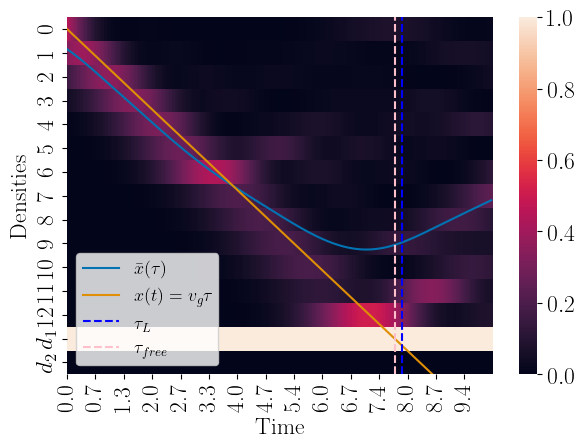

In [65]:

print(tau_0b, tau_b, tau_bL)
print("estimated time to hit the far wall: ", tau_L)

# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(traject,)
ax.set_xlabel("Time")
ax.set_ylabel("Densities")
plt.plot(x_av+0.5,label=r"$\bar{x}(\tau)$") # the 0.5 is so the values correspond to the ticks so its easier to visualize
plt.plot(xvg+0.5, label= r"$x(t)=v_g \tau$")
# plot time or arrival in index coordinates
delta_tau = times[1]- times[0]
ax.axvline(tau_L/delta_tau, label=r"$\tau_{L}$", linestyle="dashed", c='blue')
ax.axvline(tau_free/delta_tau, label=r"$\tau_{free}$", linestyle="dashed", c="pink")

#ax.axhspan(param_dict["bond_index"], param_dict["bond_index"], alpha=0.5)

# lattice ticks
site_ticks = list(range(0,param_dict["L_qpc"])) + [r"$d_1$",r"$d_2$"]
tick_posy = np.asarray(range(0,len(site_ticks))) + 0.5
ax.set_yticks(tick_posy,site_ticks);

# time ticks
tick_posx = np.arange(0,len(times),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)
ax.set_xticks(tick_posx,xtick_label);

plt.legend()
plt.tight_layout()


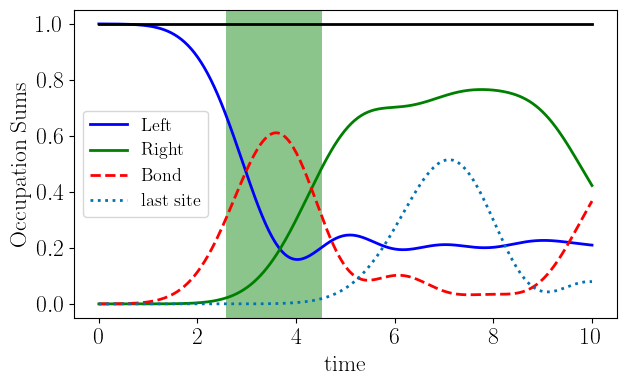

In [63]:
fig, ax = plt.subplots(1,1,figsize=(7,4))

ax.plot(times, n_left, label="Left", c='blue', linewidth=2)
ax.plot(times,n_right,label="Right", c='green',linewidth=2)
ax.plot(times,n_bond,label="Bond", linestyle="dashed", c='red',linewidth=2)
ax.plot(times,n_last,label="last site", linestyle="dotted",linewidth=2)
ax.plot(times,n_left+n_right+n_bond, c = 'black'
        ,linewidth=2)

# plot full width at half maximum at bond
plt.axvspan(bond_root[0], bond_root[1], facecolor='g', alpha=0.45)

ax.set_xlabel("time")
ax.set_ylabel("Occupation Sums")
ax.legend()


## Comparisson with Scattering Calculations

# Constant $t$ , $k$ and variable $\Omega$

here we always look at $\Omega = {0.1, 0.5,1.0 }$


In [91]:
Lqpc = 13
maxtime = 10.0
bw = 0.8
k0 = 0.1
jp = 1.0
t = 2.0
dd_init = "first"
file_list = [
            "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om0.1_dd0{}.hdf5".format(Lqpc,maxtime,bw,k0,jp,t,dd_init), 
            "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om0.5_dd0{}.hdf5".format(Lqpc,maxtime,bw,k0,jp,t,dd_init), 
            "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om1.0_dd0{}.hdf5".format(Lqpc,maxtime,bw,k0,jp,t,dd_init), 
            ]


{'L_qpc': 13, 'max_time': 10.0, 'tsteps': 200, 'bond_index': 6, 'band_width': 0.8, 'g_velocity': 0.1, 'J_prime': 1.0, 't': 2.0, 'Omega': 0.1}
{'L_qpc': 13, 'max_time': 10.0, 'tsteps': 200, 'bond_index': 6, 'band_width': 0.8, 'g_velocity': 0.1, 'J_prime': 1.0, 't': 2.0, 'Omega': 0.5}
{'L_qpc': 13, 'max_time': 10.0, 'tsteps': 200, 'bond_index': 6, 'band_width': 0.8, 'g_velocity': 0.1, 'J_prime': 1.0, 't': 2.0, 'Omega': 1.0}


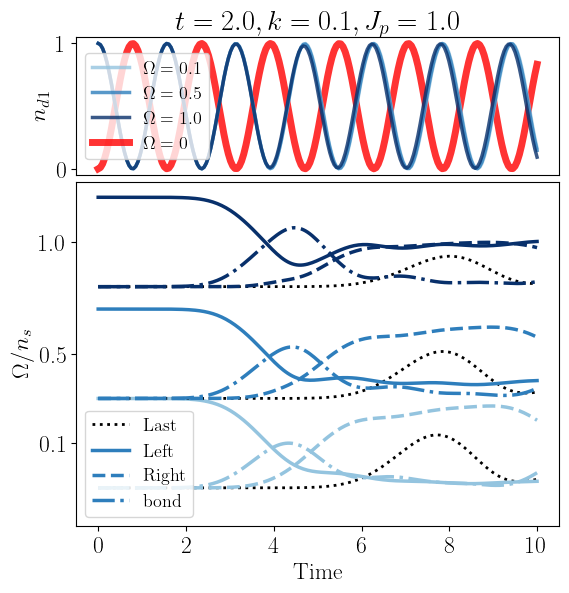

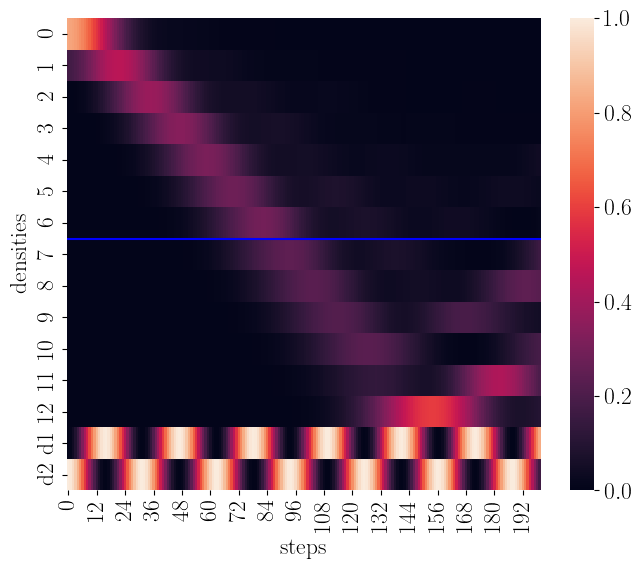

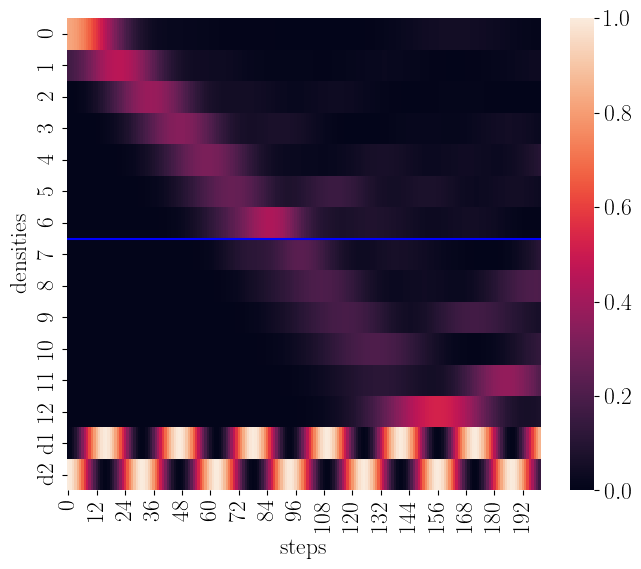

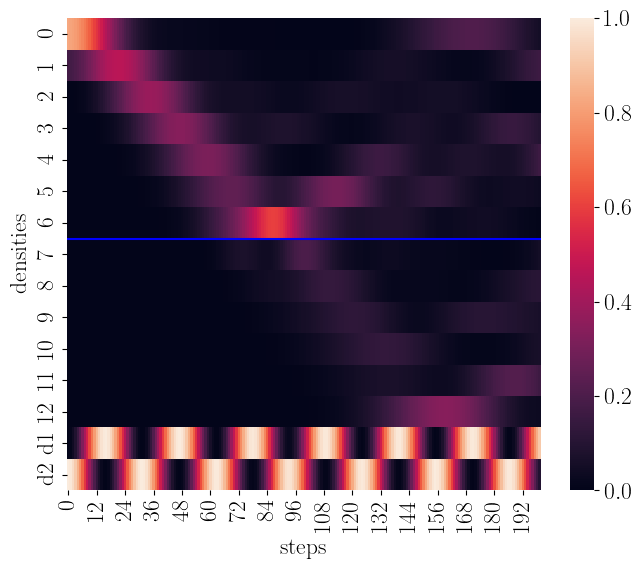

In [92]:
colors = plt.cm.Blues(np.linspace(0.4,1,len(file_list)))

tick_positions = []
omega_labels = []

fig, axd = plt.subplots(2,1,figsize=(6,7),sharex=True)

for f in range(0,len(file_list)):
    file_ = file_list[f]
    # for the double dots
    param_dict, times, n_bond, n_left, n_right, n_last, n_d1, n_d2, traject = load_data(data_route, file_)
    Om = param_dict["Omega"]
    
    print(param_dict)
    
    axd[0].plot(times, n_d2, c = colors[f], alpha=0.8 ,linewidth=2.5, 
                label=r'$\Omega={}$'.format(param_dict["Omega"]))    
    
    axd[1].plot(times,n_last+(2.5*Om), linestyle="dotted",linewidth=2,c='black')
    axd[1].plot(times, n_left+(2.5*Om), c = colors[f], alpha=1.0 ,linewidth=2.5,)
    axd[1].plot(times, n_right+(2.5*Om), c = colors[f], alpha=1.0 ,linewidth=2.5,linestyle="dashed")
    axd[1].plot(times, n_bond+(2.5*Om), c = colors[f], alpha=1.0 ,linewidth=2.5,linestyle="dashdot")

    tick_positions.append(2.5*Om+0.5)
    omega_labels.append(Om)  
    
    # for the trajectories ----------------
    fig_traj, ax_traj = plt.subplots(1,1,figsize=(7.0,6))
    
    # plot the occupations as a heatmap with lattice site in the y axis and time on the x
    sns.heatmap(traject, ax=ax_traj)
    ax_traj.set_xlabel("steps")
    ax_traj.set_ylabel("densities")
    ax_traj.axhline(param_dict["bond_index"]+1,c='blue')

    site_ticks = list(range(0,13)) + ["d1","d2"]
    tick_pos = np.asarray(range(0,15)) + 0.5

    ax_traj.set_yticks(tick_pos,site_ticks);
    fig_traj.tight_layout()
    fig_traj.savefig("../plots/QPC_double_dot/traj_L={:.2f}_tdot={:.2f}_K={}_Jp={}_dd_{}_om={}.png".format(Lqpc, t, k0,jp,
                                                                                                           dd_init,Om),
                         dpi=400)
    
axd[1].plot(0,0,linestyle="dotted",linewidth=2.0,label='Last', c='black')
axd[1].plot(0,0,linestyle="solid",linewidth=2.5,label='Left', c=colors[1])
axd[1].plot(0,0,linestyle="dashed",linewidth=2.5,label='Right',c=colors[1])
axd[1].plot(0,0,linestyle="dashdot",linewidth=2.5,label='bond',c=colors[1])


# analytic expectation for decoupled case
rabi_osc = np.sin(t*times)**2

axd[0].plot(times, rabi_osc, linewidth=5, alpha=0.8, c='red' ,label=r"$\Omega = 0$",zorder=0)


axd[0].set_title(r"$t = {}, k = {}, J_p={}$".format(t,k0, jp))
axd[0].legend()
axd[0].set_ylabel(r"$n_{d1}$")
axd[0].set_box_aspect(1/3.5)
axd[0].xaxis.set_ticks_position('none') 

axd[1].set_xlabel(r"Time")
axd[1].set_ylabel(r"$\Omega / n_{s}$")
axd[1].set_yticks(tick_positions, omega_labels)
axd[1].legend()
fig.subplots_adjust(hspace=-0.62)

fig.tight_layout()
fig.savefig("../plots/QPC_double_dot/densities_L={:.2f}_tdot={:.2f}_K={}_Jp={}_dd_{}.pdf".format(Lqpc, t,
                                                                                                 k0,jp,dd_init))

